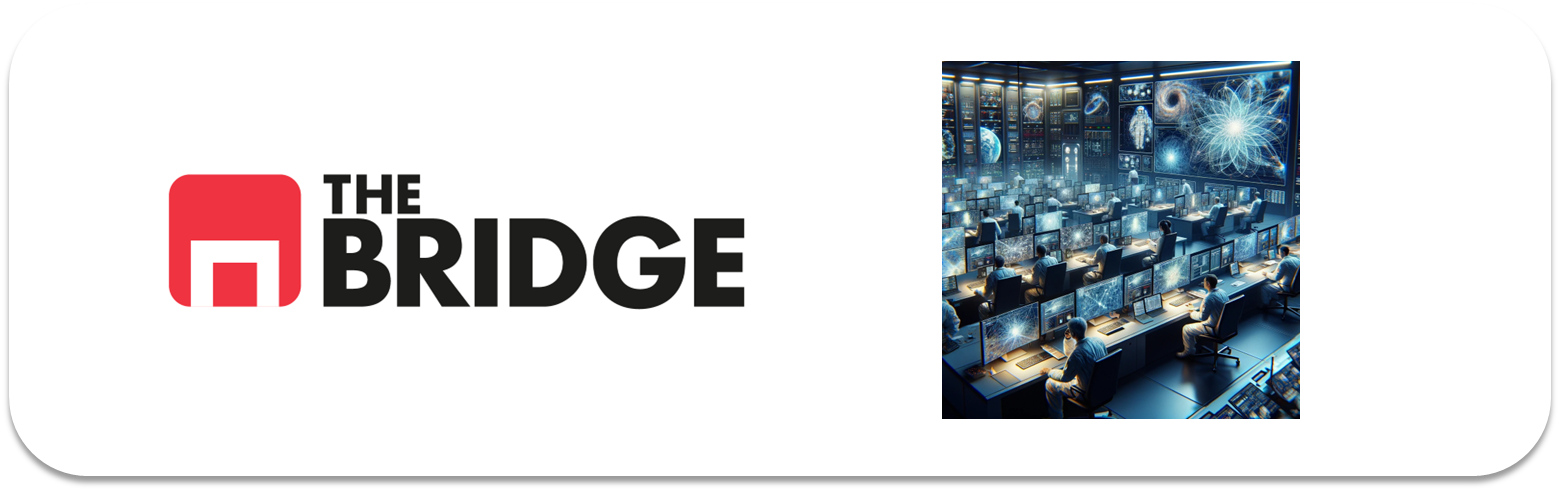

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La pr√°ctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcci√≥n de un modelo de clasificaci√≥n de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendr√°s que descar los directorios de im√°genes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesi√≥n en vivo para que punt√∫e adecuadamente.  
* Recuerda tambi√©n que no es necesario que est√© perfecta, s√≥lo es necesario que se vea el esfuerzo. 
* Esta pr√°ctica se resolver√° en la sesi√≥n en vivo correspondiente y la soluci√≥n se publicar√° en el repo del curso. 

### Ejercicio 0

Importa los paquetes y m√≥dulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
#import bootcampviztools as tds
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from keras.applications.mobilenet_v2 import MobileNetV2,decode_predictions

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualizaci√≥n, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificaci√≥n de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este √∫ltimo si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluaci√≥n contra test, el report de clasificaci√≥n y la matriz de confusi√≥n.

5. Hacer un fine-tuning con la misma cabeza dise√±ada en el punto anterior. Mostrar la evaluaci√≥n contra test, el report de clasificaci√≥n y la matriz de confusi√≥n.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de im√°genes.



In [2]:

root_path = './data/'
train_path = os.path.join(root_path, "seg_train", "seg_train")  # Asegurar la ruta correcta
test_path = os.path.join(root_path, "seg_test", "seg_test")

def read_data(directorio, reshape_dim=(224, 224)):
    X = []
    y = []

    for folder in os.listdir(directorio):
        folder_path = os.path.join(directorio, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file)

                if not os.path.isfile(image_path):
                    continue  # Saltar si no es un archivo

                if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    print(f"Saltando archivo no v√°lido: {file}")
                    continue

                print(f"Intentando leer: {image_path}")
                image = cv2.imread(image_path)

                if image is None:
                    print(f"Error al cargar la imagen: {image_path}")
                    continue

                image = cv2.resize(image, reshape_dim)

                X.append(image)
                y.append(folder)

    return np.array(X), np.array(y)

# Llamada a la funci√≥n
X_train, y_train = read_data(train_path)
print(f"Im√°genes cargadas: {len(X_train)}")


Intentando leer: ./data/seg_train\seg_train\buildings\0.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10006.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\1001.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10014.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10018.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10029.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10032.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10056.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\1009.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10113.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\1012.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10126.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10144.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10151.jpg
Intentando leer: ./data/seg_train\seg_train\buildings\10161.jpg
Intentando leer: ./data/seg_train\seg_train\bui

In [3]:
X_test, y_test = read_data(test_path)

Intentando leer: ./data/seg_test\seg_test\buildings\20057.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20060.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20061.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20064.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20073.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20074.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20078.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20083.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20094.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20096.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20113.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20131.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20140.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20177.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20186.jpg
Intentando leer: ./data/seg_test\seg_test\buildings\20206.jpg
Intentan

In [4]:
X_train.shape
num_classes = len(set(y_train))

In [5]:
from sklearn.preprocessing import LabelEncoder

# Crear y ajustar el LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convertir clases a n√∫meros
y_test = label_encoder.transform(y_test)  # Aplicar la misma conversi√≥n a test

# Crear un diccionario de mapeo {√≠ndice: clase}
class_mapping = dict(enumerate(label_encoder.classes_))

print("Clases codificadas:", class_mapping)  # Ver el mapeo de clases


Clases codificadas: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [6]:
print(type(y_test))
print(y_test[:1000])  # Mostrar algunos valores para ver el formato


<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

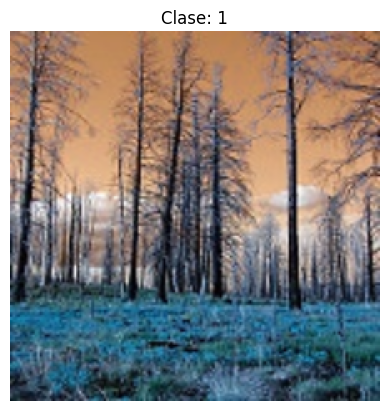

In [7]:

# Mostrar la primera imagen
plt.imshow(X_train[3300])  # X_train contiene im√°genes en formato array
plt.title(f"Clase: {y_train[3300]}")
plt.axis("off")  # Ocultar ejes
plt.show()

In [8]:

base_model = MobileNetV2(input_shape=(224, 224, 3),
                   include_top=False,  # No incluir la parte de clasificaci√≥n de ImageNet
                   weights="imagenet")  # Cargar pesos preentrenados


base_model.summary()


Model: "mobilenetv2_1.00_224"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 224, 224,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Conv1 (Conv2D)      ‚îÇ (None, 112, 112,  ‚îÇ        864 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ                     ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bn_Conv1            ‚îÇ (None, 112, 112,  ‚îÇ        128 ‚îÇ Conv1[0][0]       ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Conv1_relu (ReLU)   ‚îÇ (None, 112, 112,  ‚îÇ          0 ‚îÇ bn_Conv1[0][0]    ‚îÇ
‚îÇ                     ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ expanded_conv_dept‚Ä¶ ‚îÇ (None, 112, 112,  ‚îÇ        288 ‚îÇ Conv1_relu[0][0]  ‚îÇ
‚îÇ (DepthwiseConv2D)   ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ expanded_conv_dept‚Ä¶ ‚îÇ (None, 112, 112,  ‚îÇ        128 ‚îÇ expanded_conv_de‚Ä¶ ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ expanded_conv_dept‚Ä¶ ‚îÇ (None, 112, 112,  ‚îÇ          0 ‚îÇ expanded_conv_de‚Ä¶ ‚îÇ
‚îÇ (ReLU)              ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ expanded_conv_proj‚Ä¶ ‚îÇ (None, 112, 112,  ‚îÇ        512 ‚îÇ expanded_conv_de‚Ä¶ ‚îÇ
‚îÇ (Conv2D)            ‚îÇ 16)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ expanded_conv_proj‚Ä¶ ‚îÇ (None, 112, 112,  ‚îÇ         64 ‚îÇ expanded_conv_pr‚Ä¶ ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 16)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
from tensorflow.keras import layers, models

# Crear la nueva cabeza con m√°ximo 2 capas densas ocultas y una de salida
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation="relu")(x)  # Primera capa densa oculta
x = layers.Dense(64, activation="relu")(x)   # Segunda capa densa oculta
output = layers.Dense(num_classes, activation="softmax")(x)  # Capa de salida

# Definir el modelo completo
model = models.Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Aumentar im√°genes para mejorar generalizaci√≥n
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_path,  # Ruta donde est√°n las carpetas con im√°genes
    target_size=(224, 224),  # Tama√±o de imagen esperado por MobileNetV2
    batch_size=32,
    class_mode="sparse"  # Si las etiquetas son n√∫meros
)


Found 14034 images belonging to 6 classes.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)


history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

c:\Users\rodri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
439/439 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1178s 3s/step - accuracy: 0.7768 - loss: 0.6399 - val_accuracy: 0.3130 - val_loss: 8.4470
Epoch 2/10
439/439 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1129s 3s/step - accuracy: 0.8590 - loss: 0.4026 - val_accuracy: 0.4607 - val_loss: 3.6452
Epoch 3/10
439/439 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1120s 3s/step - accuracy: 0.8822 - loss: 0.3514 - val_accuracy: 0.2940 - val_loss: 8.1571
Epoch 4/10
439/439 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1120s 3s/step - accuracy: 0.8888 - loss: 0.3183 - val_accuracy: 0.4247 - val_loss: 5.7193
Epoch 5/10
439/439 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1123s 3s/step - accuracy: 0.8933 - loss: 0.3057 - val_accuracy: 0.4087 - val_loss: 4.9862
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# Predicciones
y_pred = np.argmax(model.predict(X_test), axis=1)


üîπ **Reporte de Clasificaci√≥n:**

              precision    recall  f1-score   support

           0       0.35      0.90      0.50       437
           1       1.00      0.06      0.11       474
           2       0.64      0.29      0.40       553
           3       0.43      0.73      0.54       525
           4       0.57      0.43      0.49       510
           5       0.64      0.40      0.49       501

    accuracy                           0.46      3000
   macro avg       0.60      0.47      0.42      3000
weighted avg       0.61      0.46      0.42      3000



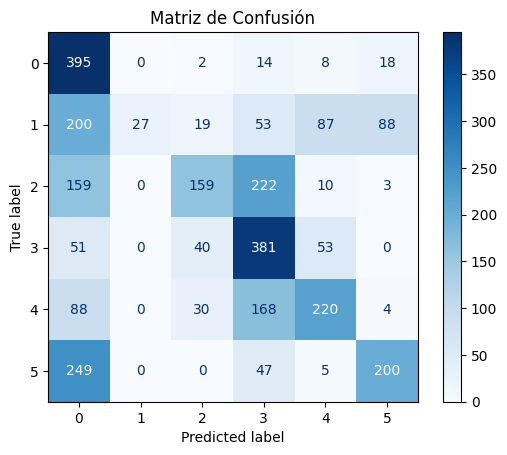

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Reporte de clasificaci√≥n
print("\nüîπ **Reporte de Clasificaci√≥n:**\n")
print(classification_report(y_test, y_pred))

# Matriz de confusi√≥n
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusi√≥n correctamente
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap="Blues", values_format="d")

plt.title("Matriz de Confusi√≥n")
plt.show()


In [18]:
# Descongelar las √∫ltimas 20 capas para Fine-Tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compilar nuevamente con una tasa de aprendizaje baja (evita perder lo aprendido)
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate bajo para ajustar sin sobreescribir
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Continuar entrenamiento con Fine-Tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,  # Fine-tuning se hace pocas √©pocas
    validation_data=(X_test, y_test),
    steps_per_epoch=100,
    validation_steps=50,
    callbacks=[early_stopping]
)


Epoch 1/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 346s 3s/step - accuracy: 0.8835 - loss: 0.3168 - val_accuracy: 0.5373 - val_loss: 2.8139
Epoch 2/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 312s 3s/step - accuracy: 0.9090 - loss: 0.2833 - val_accuracy: 0.5987 - val_loss: 2.1712
Epoch 3/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 322s 3s/step - accuracy: 0.9036 - loss: 0.3025 - val_accuracy: 0.6580 - val_loss: 1.7687
Epoch 4/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 326s 3s/step - accuracy: 0.9107 - loss: 0.2572 - val_accuracy: 0.6950 - val_loss: 1.4666
Epoch 5/10
 39/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2:47 3s/step - accuracy: 0.9151 - loss: 0.2468

c:\Users\rodri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 161s 2s/step - accuracy: 0.9097 - loss: 0.2634 - val_accuracy: 0.7087 - val_loss: 1.3723
Epoch 6/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 334s 3s/step - accuracy: 0.9142 - loss: 0.2440 - val_accuracy: 0.7443 - val_loss: 1.1451
Epoch 7/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 359s 4s/step - accuracy: 0.9188 - loss: 0.2362 - val_accuracy: 0.7630 - val_loss: 1.0399
Epoch 8/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 327s 3s/step - accuracy: 0.9199 - loss: 0.2501 - val_accuracy: 0.7763 - val_loss: 0.9575
Epoch 9/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 319s 3s/step - accuracy: 0.9289 - loss: 0.2241 - val_accuracy: 0.7793 - val_loss: 0.9124
Epoch 10/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 150s 1s/step - accuracy: 0.9103 - loss: 0.2541 - val_accuracy: 0.7837 - val_loss: 0.8

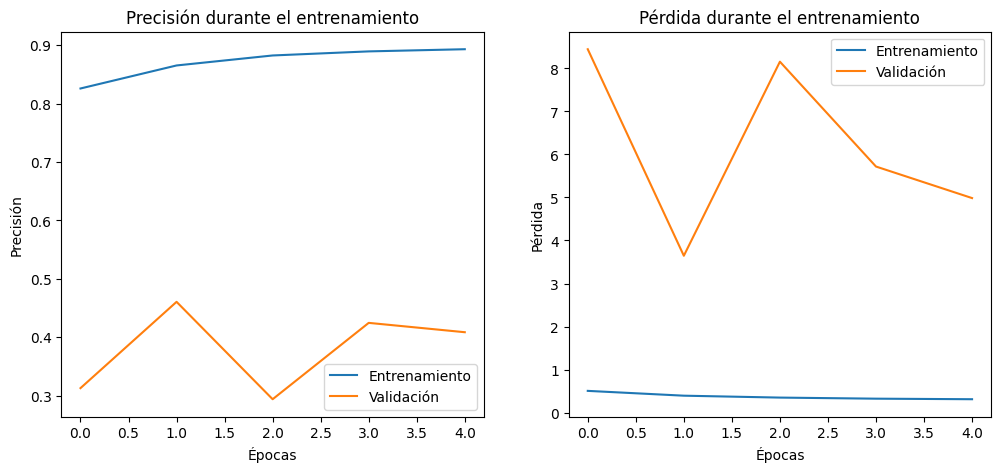

In [19]:

# Graficar la precisi√≥n
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validaci√≥n")
plt.xlabel("√âpocas")
plt.ylabel("Precisi√≥n")
plt.legend()
plt.title("Precisi√≥n durante el entrenamiento")

# Graficar la p√©rdida
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validaci√≥n")
plt.xlabel("√âpocas")
plt.ylabel("P√©rdida")
plt.legend()
plt.title("P√©rdida durante el entrenamiento")

plt.show()


94/94 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 57s 562ms/step


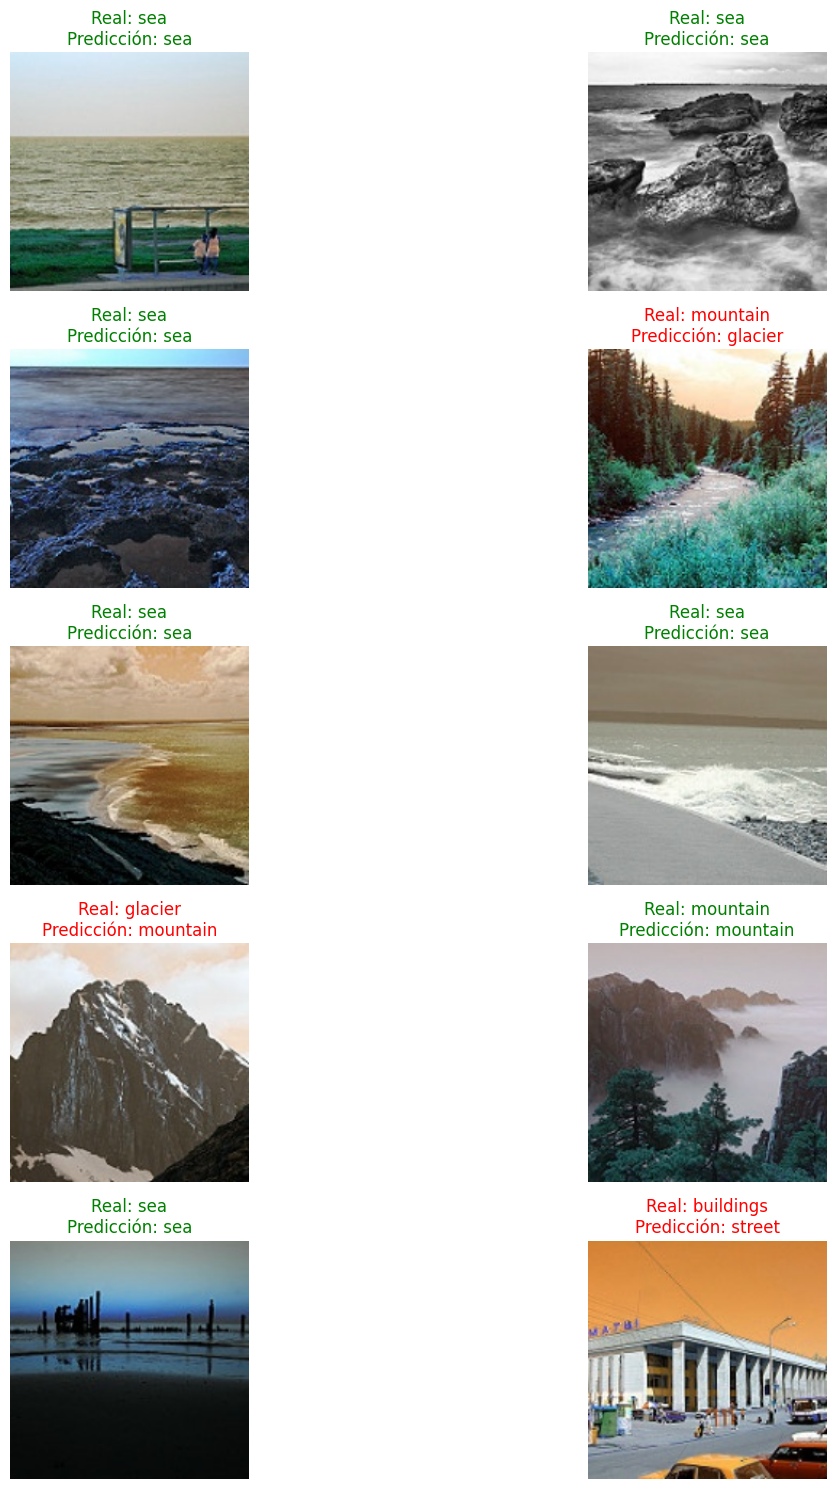

In [20]:

# Seleccionar 10 im√°genes aleatorias
num_images_to_show = 10
indices = np.random.choice(len(X_test), num_images_to_show, replace=False)

# Obtener predicciones
y_pred = np.argmax(model.predict(X_test), axis=1)

# Graficar im√°genes con predicciones
plt.figure(figsize=(15, 15))
for i, img_idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    plt.imshow(X_test[img_idx].astype("uint8"))
    plt.axis("off")

    # Obtener la etiqueta real y la predicci√≥n
    real_label = class_mapping[y_test[img_idx]]
    predicted_label = class_mapping[y_pred[img_idx]]

    # Definir color seg√∫n si la predicci√≥n fue correcta
    color = "green" if real_label == predicted_label else "red"

    plt.title(f"Real: {real_label}\nPredicci√≥n: {predicted_label}", color=color, fontsize=12)

plt.tight_layout()
plt.show()
